In [1]:
from selenium import webdriver
import numpy as np
import glob
import os
import time
import datetime
import pandas as pd
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium.common.exceptions import TimeoutException
from datetime import datetime
import tqdm
%matplotlib inline

### Scrapping website

In [2]:
d = webdriver.PhantomJS()
d.get("https://bitinfocharts.com/")

In [3]:
table = d.find_element_by_id('main_body').find_element_by_tag_name('tbody').get_attribute('innerHTML')
bs = BeautifulSoup(table, "lxml")
d.quit()

In [4]:
df = pd.DataFrame()
df['Columns'] = [k.find('td').getText() for k in bs.find_all('tr')]
for crypto in ['btc', 'eth', 'ltc']:
    df[crypto.upper()] = [p.getText() for p in bs.find_all(class_='c_%s' % crypto)]

### Cleaning dataframe

In [6]:
df2 = df.copy()
stopwords = ['BTC', 'ETH', 'LTC']
def remove_chars(x):
    num = re.sub('[^0-9]','', x)
    if len(str(num)) < 3:
        return x
    else:
        return num
    
def convert_number(x):
    return float(x.replace(',',''))

def remove_crypt(x):
    for k in stopwords:
        if k in x:
            return convert_number(x[:x.index(k)])
        
def clean_reward(x):
    for k in stopwords:
        if k in x:
            x = x[:x.index(k)]
            return tuple(map(float, x.replace(',','').split('+')))

df2.loc[0] = df2.loc[0].apply(lambda x:x[:x.index('(')] if '(' in x else x)
df2.loc[1] = df2.loc[1].apply(remove_chars)
df2.loc[2] = df2.loc[2].apply(lambda x:convert_number(x[x.find('$')+1:x.find('USD')]) if 'USD' in x else x)
df2.loc[3] = df2.loc[3].apply(lambda x:convert_number(x[x.find('$')+1:x.find('USD')]) if 'USD' in x else x)
df2.iloc[4, 1:] = df2.iloc[4, 1:].apply(convert_number)
for p in range(6,10):
    df2.iloc[p, 1:] = df2.iloc[p, 1:].apply(remove_crypt)
df2.iloc[14, 1:] = df2.iloc[14, 1:].apply(clean_reward)
df2.iloc[15, 1:] = df2.iloc[15, 1:].apply(clean_reward)

In [7]:
df2.head(20)

,Columns,BTC,ETH,LTC
0,,Bitcoin,Ethereum,Litecoin
1,Total,16677874,95845937,53914808
2,Price,8227.86,363.16,71.99
3,Market Capitalization,1.37223e+11,3.48073e+10,3.88108e+09
4,Transactions last 24h,300690,506225,27056
5,Transactions avg. per hour,"12,529","21,093","1,127"
6,Sent last 24h,4.98305e+06,1.54418e+07,1.80088e+07
7,Sent avg. per hour,207627,643408,750365
8,Avg. Transaction Value,16.57,30.5,665.61
9,Median Transaction Value,0.066,0.02,5.15


### BTC.com

In [8]:
# site : blockchain info / btc.com
# scrapper les N derniers blocks pour avoir les transactions fees 

In [103]:
def scrap_one_day(year, month, day):
    """
    Scrapper to get all the block of one day on BTC.com
    :param date: info about the day to scrap
    """
    d = webdriver.PhantomJS()
    d.get("https://btc.com/block?date=%s-%s-%s" % (year, month, day))
    table = d.find_element_by_class_name('table').find_element_by_tag_name('tbody').get_attribute('innerHTML')
    bs = BeautifulSoup(table, "lxml")
    d.quit()
    row = bs.find_all('tr')[1:]
    cols = pd.Series([k.getText() for k in bs.find_all('tr')[0].find_all('th')][:-1]), 
    values = pd.DataFrame([[k.getText().strip() for k in r.find_all('td')][:-1] for r in row])
    print('Day %s/%s done!' % (day, month))
    return cols, values

In [43]:
month = datetime.now().month
year = datetime.now().year
current_day = datetime.now().day

df = pd.DataFrame()
for dd in range(current_day, current_day-10, -1):
    cols, temp = scrap_one_day(year, month, dd)
    df = pd.concat([df, temp])
df = df.reset_index(drop=True)
df.columns = cols[0]

Day 24/11 done!
Day 23/11 done!
Day 22/11 done!
Day 21/11 done!
Day 20/11 done!
Day 19/11 done!
Day 18/11 done!
Day 17/11 done!
Day 16/11 done!
Day 15/11 done!


In [44]:
# Remove the "relayé par"
if len(df.columns) > 8:
    del df[df.columns[1]]

# Remove ',' in number 
for col in df.columns[:6]:
    df[col] = df[col].apply(lambda x:float(x.replace(',', '')))
df['RewardFee'] = df[df.columns[6]].apply(lambda x:float(x[x.index('+ ')+2:x.index(' BTC')]))

In [45]:
df.head(5)

,Height,Nombre de transactions,Stripped Size(B),Taille(B),Weight,Avg Fee Per Tx,Récompense,Heure,RewardFee
0,495889.0,1783.0,936938.0,1182297.0,3993111.0,0.000363,12.5 + 1.44839311 BTC,2017-11-24 13:16:21,1.448393
1,495888.0,1893.0,965073.0,1097678.0,3992897.0,0.000495,12.5 + 1.97754731 BTC,2017-11-24 13:09:12,1.977547
2,495887.0,2244.0,984305.0,1045159.0,3998074.0,0.000448,12.5 + 1.79223714 BTC,2017-11-24 12:58:37,1.792237
3,495886.0,2421.0,979736.0,1053536.0,3992744.0,0.000663,12.5 + 2.64774008 BTC,2017-11-24 12:47:07,2.647740
4,495885.0,2417.0,957333.0,1121086.0,3993085.0,0.000388,12.5 + 1.55023504 BTC,2017-11-24 12:26:55,1.550235


In [49]:
writer = pd.ExcelWriter('Info_blocks_bitcoin.xlsx')
df.to_excel(writer, sheet_name='Info Blocks Bitcoin')
writer.save()

In [38]:
# Remove block with only one transaction
df[df[df.columns[1]] > 10][df.columns[1]].mean(), df[df[df.columns[1]] > 10][df.columns[1]].std()

(2018.1460296096905, 586.9336681853798)

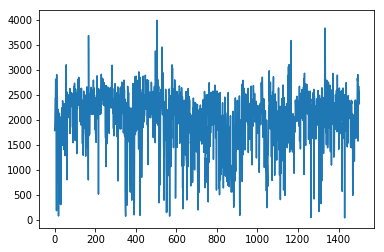

In [39]:
df[df[df.columns[1]] > 10][df.columns[1]].plot()

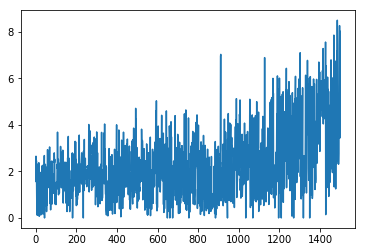

In [33]:
df.RewardFee.plot()

### EtherScan

In [37]:
def scrap_one_day_ether(p_number, verbose=False):
    """
    Scrapper to get all the block of one day on EtherScan
    :param p_number: page number to scrap
    :param verbose: boolean for verbose
    """
    d = webdriver.Chrome()
    try:
        d.set_page_load_timeout(7)
        d.get("https://etherscan.io/blocks?p=%s" % p_number)
    except TimeoutException:
        pass
    table = d.find_element_by_class_name('table').find_element_by_tag_name('tbody').get_attribute('innerHTML')
    thead = d.find_element_by_class_name('table').find_element_by_tag_name('thead').get_attribute('innerHTML')
    bs = BeautifulSoup(table, "lxml")
    thead = BeautifulSoup(thead, "lxml")
    d.quit()
    cols = pd.Series([k.getText() for k in thead.find_all('th')]) 
    row = bs.find_all('tr')
    values = pd.DataFrame([[k.getText().strip() for k in r.find_all('td')] for r in row])
    time = pd.Series([r.find_all('td')[1].span.attrs['data-original-title'] for r in row])
    if verbose:
        print('Page %s done' % p_number)
    return cols, values, time

In [38]:
# It may take some time (ChromeDriver faster than PhantomJS, can get stucked)
# 1m20s for 500 blocks ie 0.16s/block
df = pd.DataFrame()
page_number_max = int(1000/25) # 25 block per page
for dd in range(1, page_number_max+1):
    cols, temp, time = scrap_one_day_ether(dd)
    temp.columns = cols.values
    temp['Age'] = time
    df = pd.concat([df, temp])

In [52]:
# Remove duplicates, Ethereum blocks can be faster than scrapping
df = df.drop_duplicates(df.columns[0])
df = df.reset_index(drop=True)
df[df.columns[8]] = df[df.columns[8]].apply(lambda x:float(x[:x.find(' E')]))
df[df.columns[7]] = df[df.columns[7]].apply(lambda x:float(x[:x.find(' G')].replace(',', '')) if not '-' in x else 0)
df[df.columns[2]] = df[df.columns[2]].apply(float)

### Litecore.io

In [168]:
def scrap_one_day_ltc(year, month, day):
    """
    Scrapper to get all the block of one day on BTC.com
    :param date: info about the day to scrap
    """
    d = webdriver.Chrome()
    d.get("https://insight.litecore.io/blocks-date/%s-%s-%s" % (year, month, day))
    time.sleep(1)
    table = d.find_element_by_class_name('table').get_attribute('innerHTML')
    #table = d.find_element_by_class_name('table').find_element_by_tag_name('tbody').get_attribute('innerHTML')
    bs = BeautifulSoup(table, "lxml")
    d.quit()
    #return bs 
    row = bs.find_all('tr')[1:]
    cols = pd.Series([k.getText() for k in bs.find_all('tr')[0].find_all('th')]), 
    values = pd.DataFrame([[k.getText().strip() for k in r.find_all('td')] for r in row])
    return cols, values

In [170]:
month = datetime.now().month
year = datetime.now().year
current_day = datetime.now().day

df = pd.DataFrame()
for dd in range(current_day, current_day-3, -1):
    cols, temp = scrap_one_day_ltc(year, month, dd)
    df = pd.concat([df, temp])
df.columns = cols[0]

if not df.iloc[0][1]:
    df = df.drop(0)

df = df.reset_index(drop=True)
df[df.columns[2]] = df[df.columns[2]].apply(float)

In [186]:
df.head()

,Height,Timestamp,Transactions,Mined by,Size
1,1318891,"Nov 24, 2017 3:01:05 PM",77.0,,21554
2,1318890,"Nov 24, 2017 2:59:39 PM",52.0,,23581
3,1318889,"Nov 24, 2017 2:56:45 PM",72.0,,35848
4,1318888,"Nov 24, 2017 2:56:07 PM",14.0,AntMiner,6187
5,1318887,"Nov 24, 2017 2:52:49 PM",28.0,AntMiner,12669
